In [1]:
######################################
######################################
###### CLASSIFICATION VIZ MNIST ######
######################################
######################################

In [80]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1, as_frame=False)
mnist.keys()

/home/colin/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# sklearn loaded datasets have similar dictionary structure, including useful keys as given above
print(mnist['DESCR'])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape # 70k labeled digits mapped to 28x28 pixels
# X is a pandas dataframe

(70000, 784)

In [5]:
y.shape

(70000,)

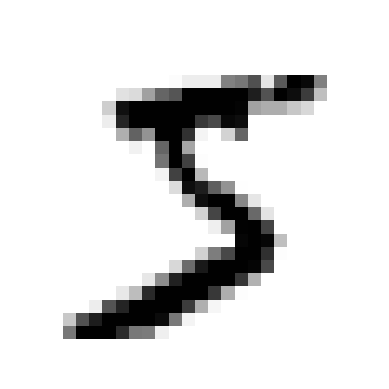

In [6]:
# Now let's look at a few digits in the MNIST dataset
import matplotlib as mpl
import matplotlib.pyplot as plt

# X[n] replaced now with X.loc[n,:] - check python version in use
some_digit = X.loc[0,:]
# Can't just reshape the series array - apparently one now needs to access the values to be reshapened
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
# Indeed a 'five'
y[0]

'5'

In [8]:
# Cast string labels to ints
import numpy as np
y=y.astype(np.uint8)

In [9]:
# MNIST dataset is already split into a test set and training set
# training : first 60k
# test : last 10k

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# MNIST is also already pre-shuffled!

In [10]:
######
# TRAIN A BINARY CLASSIFIER
######
# As an example, distinguish between 5 and not-5
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

#print(y_train_5)

In [11]:
# Import a stochastic gradient descent classifier and train it on entire dataset
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
# help(sgd_clf)

SGDClassifier(random_state=42)

In [13]:
# Predict w/ sgd_clf
sgd_clf.predict([some_digit])

/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [14]:
#####
# PERFORMANCE MEASURES OF A CLASSIFIER  --  CROSS-VALIDATION
#####
# Consider cross_val_score() to evaluate SGDClassifier model (w/ 3-fold cross-validation)
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [15]:
# Realizing that ~10% of images are actually 5's, a classifier that identifies "not-5" illustrates
# that 'accuracy' is not the best performance measure for classifiers (esp. of skewed datasets)
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [16]:
#######
# CONFUSION MATRIX - A BETTER WAY TO ASSESS PERFORMANCE OF A CLASSIFIER
#######
# Need set of predictions to compare with actual targets
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# Using 3-fold cross-validation; returns predictions made on each test fold - a clean prediction for each instance in training set

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
# TN - true negatives (not 5's, classified as such): 53892
# FP - false positives (not 5, but classified as 5): 687
# FN - false negative (5, but classified as non-5): 1891
# TP - true positives (5's and classified as such): 3530

# N.B. a perfect classifier would have a diagonal confusion matrix
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [19]:
### Useful metrics derived from confusion matrix
# Precision = TP / ( TP + FP )
# Recall = TP / ( TP + FN )  --->  "true positive rate": ratio of positive instances predicted correctly by classifier
from sklearn.metrics import precision_score, recall_score
prec=precision_score(y_train_5, y_train_pred)
rec=recall_score(y_train_5, y_train_pred)
print("SGDClassifier: (precision,recall) = (%.6f,%.6f)"%(prec,rec))

SGDClassifier: (precision,recall) = (0.837088,0.651171)


In [20]:
 # I.E.: this SGDClassifier correctly predicts positive class ~83.7% of the time,
    # but only detects ~65.1% of the 5s

In [21]:
# Precision and Recall scores are often combined into a so-called "F1-score",
# which computes the harmonic mean of the two
# F1 = 2 / ((1/precision) + (1/recall))
# F1 favors classifiers with similar precision & recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [22]:
# Note the trade-off between precision and recall. Adjusting the threshold within the decision_function
# either increases precision or recall at the expense of the other

# Although sklearn doesn't give direct access to the threshold, we can access the decision scores used to make
# ..predictions; we can then make our own threshold to illustrate the trade-off between precision & recall

y_scores = sgd_clf.decision_function([some_digit])
y_scores

/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [23]:
threshold=0
y_some_digit_pred = (y_scores>threshold); y_some_digit_pred

array([ True])

In [24]:
threshold=8000
y_some_digit_pred = (y_scores>threshold); y_some_digit_pred

array([False])

In [25]:
# Clearly by lowering the threshold we can increase the recall, and truly predict the image as a 5
# Yet, increasing the threshold leads to this image incorrectly being classified as "not-5"

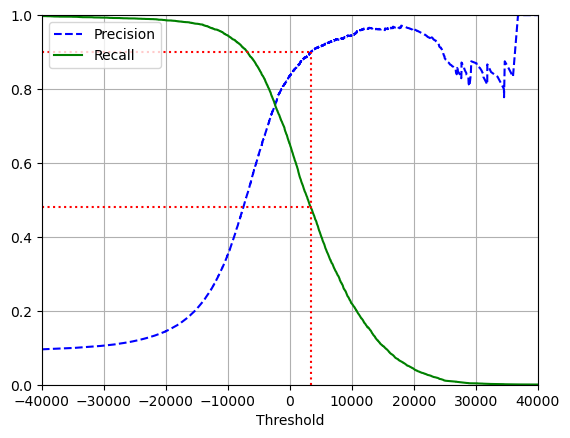

In [26]:
# To decide on an appropriate threshold to use, fetch decision scores for all instances in training set
# ..and use cross_val_predict function. Then plot recall/precision for all possible thresholds
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Get first index of precisions meeting 90%
prec90Idx=np.argmax(precisions >= 0.90)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('Threshold')
    plt.xlim([-40e3,40e3])
    plt.ylim([0,1])
    plt.vlines(thresholds[prec90Idx],0,precisions[prec90Idx],color='r',ls=':')
    plt.hlines(precisions[prec90Idx],plt.xlim()[0],thresholds[prec90Idx],color='r',ls=':')
    plt.hlines(recalls[prec90Idx],plt.xlim()[0],thresholds[prec90Idx],color='r',ls=':')
    plt.grid(axis='both')
    plt.legend()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

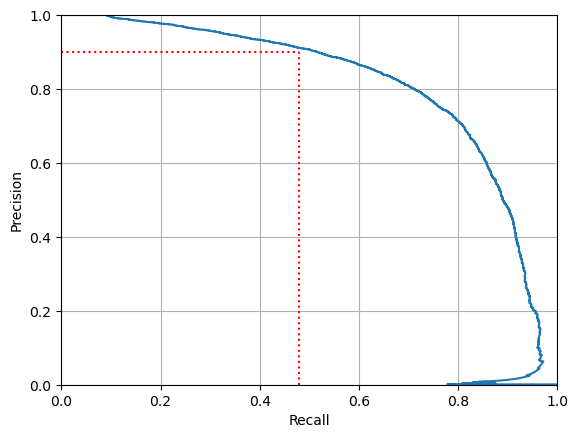

In [27]:
# Plotting precision against recall is another way to find a good balance between the two w.r.t a classifier
plt.plot(precisions,recalls)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0,1])
plt.ylim([0,1])
plt.vlines(recalls[prec90Idx],0,precisions[prec90Idx],color='r',ls=':')
plt.hlines(precisions[prec90Idx],0,recalls[prec90Idx],color='r',ls=':')
plt.grid(axis='both')

In [28]:
# Can run the following instead of SGDClassifier's predict() method to make predictions
threshold_90_precision = thresholds[prec90Idx]

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

In [31]:
# So, we have a simple classifier w/ 90% precision, but a quite low recall of ~48%

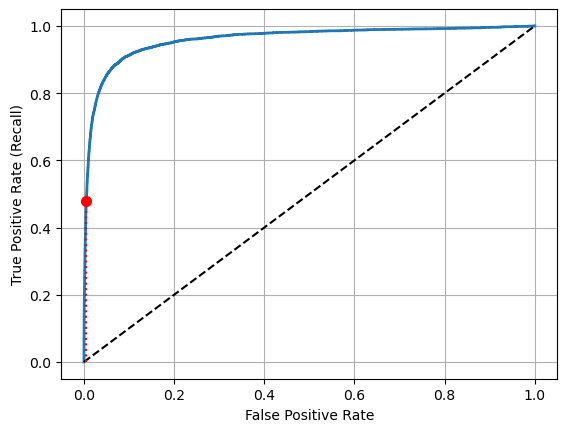

In [32]:
###############
# THE ROC CURVE - RECEIVER OPERATING CHARACTERISTIC
# i.e. recall (true pos. rate) vs. false pos. rate (FPR)
# -OR- sensitivity (recall) vs. 1-specificity

# where the false positive rate is the ratio of negative instances that are incorrectly classified as positive
# ..(FPR is also 1-[true negative rate]), where TNR = ratio of negative instances correctly classified as neg.
###############
# Use roc_curve() to compute TNR and FPR
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.grid(axis='both')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    # Chosen ratio of ~48% recall
    tprAt48=np.argmax(tpr>=0.479985)
    plt.vlines(fpr[tprAt48],0,tpr[tprAt48],color='r',ls=':')
    plt.plot(fpr[tprAt48],tpr[tprAt48],color='r',ms=7,marker='o')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [33]:
# A random classifier is represented by dashed black line above. A good classifier stays far (to upper left)
# away from that line.
# Once again, there is a trade-off: as the recall rate (true positive rate) increases, so too does the FPR

In [34]:
##### ROC Area Under Curve (AUC) # Another useful metric in comparing classifiers
# A perfect classifier will have AUC=1, and a purely random one AUC=0.5
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)
# RECALL:
# w/ y_train_5 is target vector (i.e. True for 5 and False for non-5) in training set
# & y_scores is vector of decision scores for all training set instances using cross_val_predict

0.9604938554008616

In [35]:
# ROC AUC seems to indicte a strong binary classifier, but precision-recall curve shows room for improvement
# Mostly due to few true positive instances (5's) compared to negative instances (non-5's)

In [36]:
#############
# Train RandomForestClassifier and compare ROC curve and ROC AUC score with SGDClassifier

# Need to get scores for each instance in training set
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

# y_probas_forest will be array w/ one row per instance and two columns, one for probability of pos. & neg. instance

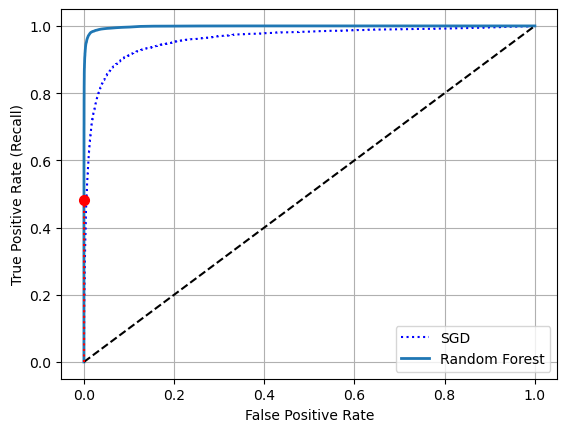

In [37]:
# Use positive class probability as scores
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [38]:
# Random Forest Classifier has a better (closer to upper left corner) ROC curve and, hence, higher ROC AUC
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [39]:
# Get the precision and recall scores for the RandomForestClassifier

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
#y_forest_pred = (y_scores_forest > threshold)
precision_forest=precision_score(y_train_5, y_train_pred_forest)
recall_forest=recall_score(y_train_5, y_train_pred_forest)
print("RandomForestClassifier: precision = %.6f , recall = %.6f"%(precision_forest,recall_forest))

RandomForestClassifier: precision = 0.990508 , recall = 0.866261


In [40]:
# Evidently the RandomForestClassifier has achieved a 99% precision with ~86.6% recall

In [41]:
#############################
#############################
# MULTI-CLASS CLASSIFICATION
#############################
#############################

In [42]:
# Try SVM classifier for all digits in training set
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit]) # where some_digit = 5

/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [43]:
# Under the hood, SVC is using one-versus-one strategy - i.e. training N(N-1)/2 classifiers
# to decide between 0 vs 1, 0 vs 2, etc.
# Highest decision score determines the prediction

# Decision scores for each class
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [44]:
# Highest decision score corresponds to class at index #5 (which happens to be '5')
np.argmax(some_digit_scores)

5

In [45]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
svm_clf.classes_[5]

5

In [47]:
# Force sklearn to use one-versus-rest or one-versus-one strategy
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [48]:
# one-versus-rest classifier in action
ovr_clf.predict([some_digit])

/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was

array([5], dtype=uint8)

In [49]:
len(ovr_clf.estimators_)

10

In [50]:
# Training a RandomForestClassifier or SGDClassifier in same easy manner
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [51]:
# Incorrectly classified as a 3! - scores assigned by SGDClassifier show high confidence in '3'
sgd_clf.decision_function([some_digit])

/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

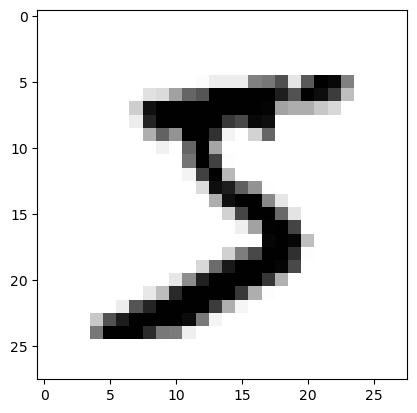

In [52]:
# Confirm a five
plt.imshow(some_digit.values.reshape(28,28),cmap='binary')

In [53]:
# Evaluate this classifier using cross-validation
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [54]:
# Although accuracy is above 85% for all folds, scaling can improve the accuracy further
# (Note, a random classifier would get 10% accuracy)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [55]:
########################
########################
#### ERROR ANALYSIS ####
########################
########################

In [56]:
# Examine the confusion matrix for the SGDClassifier
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

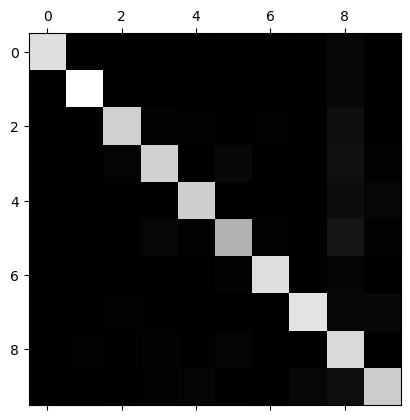

In [57]:
# As a heatmap
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()
# Very clear main diagonal indicating most digits are correctly classified. But some, 
# say 5s, are not classified as well. This could be due to fewer 5s in the dataset or just poorer performance

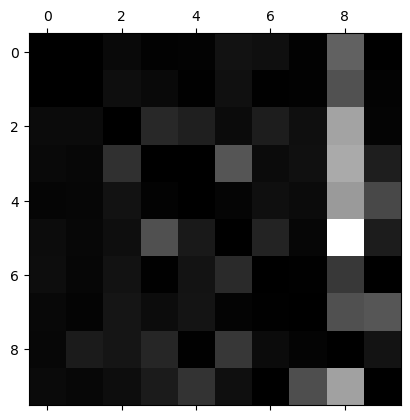

In [58]:
# To focus confusion matrix on actual errors that are made. To do so, divide each value in confusion
# matrix by number of images in corresponding class (e.g. rows).
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
# Fill diagonal with zeros to show only errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [59]:
# Since rows are actual classes and columns are predicted classes, we see this classifier makes
# considerable error in mis-classifying images as 8's. But actual 8s are well classified.

In [60]:
# Plot digits function (from https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb)
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

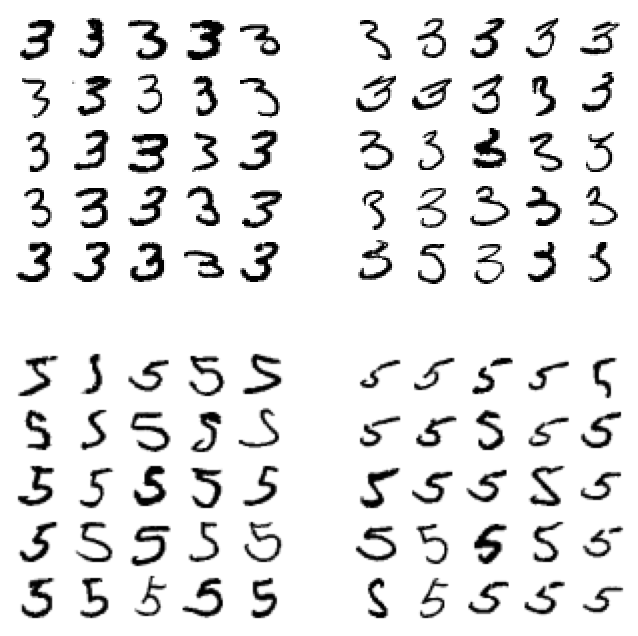

In [61]:
# Let's analyze the errors in 3s & 5s
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [62]:
# 3s and 5s are quite similar, especially in how upper line is connected to lower arc.
# The SGDClassifier used here is a linear model and assigns a weight per class to each pixel. When a new image
# is presented, the classifier sums up the weighted pixel intensities to get a score for each class.
# ... 3s and 5s differ only by a few pixels, so the mixup is understandable.
# One could say this classifier is susceptible to image shifting and rotation.

In [63]:
##############################
##############################
# MULTI-LABEL CLASSIFICATION #
##############################
##############################

In [64]:
# A simple multilabel classifier using KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [65]:
# The above creates an array containing two target labels for each digit image
# ... one label for large digits (7,8,9), and the other for odd digits

In [66]:
# Use multilabel classifier to give prediction (two labels) for 'some_digit' (i.e. a '5')
knn_clf.predict([some_digit])

/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [67]:
# Prediction is sensible - 5 is not large (i.e. 7,8,9) and is also odd

In [68]:
# One way to evaluate performance of this multilabel classifier...
# Compute average F1 score across all labels
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

In [69]:
# The above assumes all labels are equally important. This may not be the case in a dataset,
# where some target labels occur more frequently...

# Use 'weighted' scheme instead to compute a weighted average f1 score across all labels
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

In [70]:
##############################
##############################
# Multioutput Classification #
##############################
##############################

In [72]:
# This is a generalization of multilabel classification where each label can be multiclass

# Illustrated via a system that removes noise from images, taking a noisy image as input and outputing
# a clean digit image.
# This classifier's output is multilabel - one label per pixel and each label ranges from 0 to 255.

In [77]:
# Take MNIST and add noise. Target images will be original images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

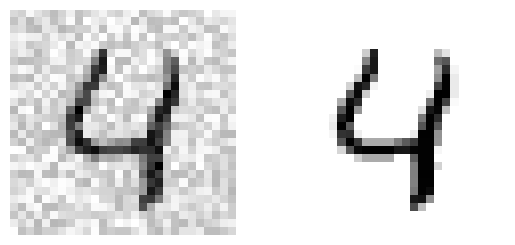

In [95]:
# Take a look at a noisy image we will start with, and the cleaned image we hope the classifier will obtain

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")


idx = 4
plt.subplot(121); plot_digit(X_test_mod.iloc[idx].values)
plt.subplot(122); plot_digit(y_test_mod.iloc[idx].values)
plt.show()

/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


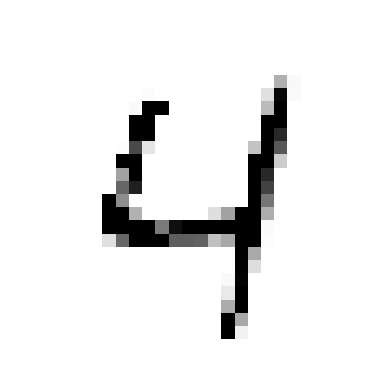

In [97]:
# Train the classifier to clean this image
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[idx].values])
plot_digit(clean_digit)